In [17]:
from __future__ import unicode_literals, print_function, division
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import time
from utils import timeSince

from cn_cn_data import get_cn_en_dataloader, to_sentence, cn_vocab, en_vocab


In [18]:
seq_len = 15
max_length = seq_len + 2
batch_size = 1

cn_vocab_size = len(cn_vocab)
en_vocab_size = len(en_vocab)

device = torch.device("cpu")
train_loader, train_dataset = get_cn_en_dataloader(seq_len, batch_size, device)
print('length of train_loader', len(train_loader))

length of train_loader 2207


In [19]:
for i, item in enumerate(train_loader):
    print(item[0].shape, item[1].shape)

    print([idx.item() for idx in item[0]])
    print(to_sentence(item[0], True))
    print([idx.item() for idx in item[1]])
    print(to_sentence(item[1], False))
    break

torch.Size([12, 1]) torch.Size([11, 1])
[2, 475, 476, 89, 242, 130, 19, 389, 76, 22, 5, 3]
['<sos>', '非', '常', '抱', '歉', '，', '我', '迟', '到', '了', ' 。', '<eos>']
[2, 12, 27, 2125, 191, 165, 12, 183, 201, 5, 3]
['<sos>', 'I', "'m", 'awfully', 'sorry', 'that', 'I', 'was', 'late', '.', '<eos>']


In [20]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden):
        embedded = self.dropout(self.embedding(input)).view(1, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden
    
    def initHidden(self, batch_size=1):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)


In [21]:
class Attention(nn.Module):
    def __init__(self, hidden_size, max_length):
        super().__init__()
        self.max_length = max_length
        self.attn = nn.Linear(hidden_size * 2, max_length)
        self.attn_combine = nn.Linear(hidden_size * 2, hidden_size, bias=False)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, embedded_input, hidden, encoder_outputs):
        # embedded_input -> (1, batch, hidden_size)
        # hidden -> (1, batch, hidden_size)
        # encoder_outputs-> (batch, seq_len, hidden_size)

        input = torch.cat((embedded_input[0], hidden[0]), 1) # (batch, hidden_size + emb_dim)
        attn_weights = self.softmax(self.attn(input)) # (batch, max_length)
        input_encoder_outputs = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs) # (1, batch, hidden_size)
                                          
        input_encoder_outputs_reapplied_embedded = torch.cat((embedded_input[0], input_encoder_outputs[0]), 1) # (batch, emb_dim + hidden_size)
        attn_combined = F.relu(self.attn_combine(input_encoder_outputs_reapplied_embedded).unsqueeze(0)) # (1, batch, hidden_size)
        return attn_combined, attn_weights


In [22]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout=0.1, max_length=max_length):
        super().__init__()
        self.attention = Attention(hidden_size, max_length)
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        # -> [batch size, seq len, hidden size]
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # input = [batch size, 1]
        # hidden = [1, batch size, hidden_size]
        # encoder_outputs = [src len, batch size, hidden_size]

        # embedded = [batch size, hidden_size]
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, hidden_size]
        embedded = embedded.unsqueeze(0)

        # attn_combined -> (1, batch, hidden_size), attn_weights -> (batch, max_length)
        attn_combined, attn_weights = self.attention(embedded, hidden, encoder_outputs)
        # output = [seq len, batch size, hidden_size], hidden = [n_layers, batch size, hidden_size]
        output, hidden = self.gru(attn_combined, hidden)
        output = self.out(output[0])
        
        return output, hidden, attn_weights


In [23]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=max_length):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    batch_size = input_tensor.size(1)
    target_length = target_tensor.size(0)

    loss = 0

    encoder_hidden = encoder.initHidden()
    encoder_outputs = torch.zeros(max_length, batch_size, encoder.hidden_size, device=device)
    for i in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[i], encoder_hidden)
        encoder_outputs[i] = encoder_output[0]

    decoder_input = input_tensor[0]

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)

            target = target_tensor[di]
            loss += criterion(decoder_output, target)
            decoder_input = target  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze(1).detach()  # detach from history as input

            target = target_tensor[di]
            loss += criterion(decoder_output, target)

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [24]:
def trainIters(encoder, decoder, train_loader, print_every=100, plot_every=10, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    # criterion = nn.CrossEntropyLoss(ignore_index=cn_vocab['<pad>'])
    n_iters = len(train_loader)

    for iter, data in enumerate(train_loader, 1):
        input_tensor, target_tensor = data

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    return plot_losses


In [25]:
hidden_size = 256
encoder1 = Encoder(cn_vocab_size, hidden_size).to(device)
decoder1 = Decoder(hidden_size, en_vocab_size).to(device)

train_losses = []
for i in range(15):
    print('--------------epoch %d--------------' % (i + 1))
    losses = trainIters(encoder1, decoder1, train_loader, print_every=500)
    train_losses = train_losses + losses

--------------epoch 1--------------
0m 23s (- 1m 21s) (500 22%) 4.2375
0m 48s (- 0m 57s) (1000 45%) 3.6136
1m 12s (- 0m 33s) (1500 67%) 3.2856
1m 36s (- 0m 9s) (2000 90%) 3.1284
--------------epoch 2--------------
0m 23s (- 1m 21s) (500 22%) 2.9229
0m 47s (- 0m 57s) (1000 45%) 2.8869
1m 12s (- 0m 33s) (1500 67%) 2.8545
1m 36s (- 0m 9s) (2000 90%) 2.8563
--------------epoch 3--------------
0m 23s (- 1m 20s) (500 22%) 2.5261
0m 47s (- 0m 57s) (1000 45%) 2.5316
1m 11s (- 0m 33s) (1500 67%) 2.5133
1m 36s (- 0m 9s) (2000 90%) 2.4944
--------------epoch 4--------------
0m 24s (- 1m 22s) (500 22%) 2.2156
0m 48s (- 0m 58s) (1000 45%) 2.2084
1m 12s (- 0m 34s) (1500 67%) 2.2647
1m 36s (- 0m 9s) (2000 90%) 2.1918
--------------epoch 5--------------
0m 23s (- 1m 21s) (500 22%) 1.9137
0m 47s (- 0m 57s) (1000 45%) 1.9908
1m 11s (- 0m 33s) (1500 67%) 2.0003
1m 36s (- 0m 9s) (2000 90%) 2.0253
--------------epoch 6--------------
0m 23s (- 1m 20s) (500 22%) 1.7332
0m 47s (- 0m 57s) (1000 45%) 1.6933
1m 

<Figure size 640x480 with 0 Axes>

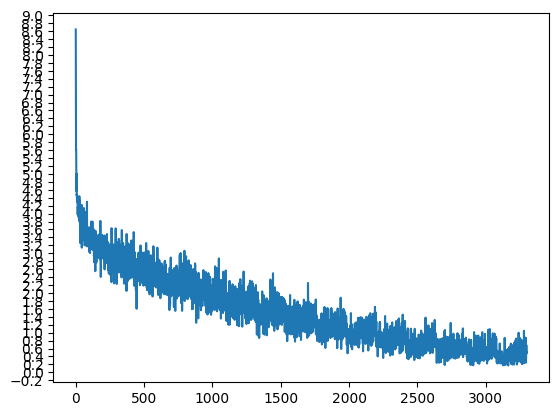

In [26]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


showPlot(train_losses)


In [27]:
encoder_path = './models/seq2seq6-encoder.pt'
decoder_path = './models/seq2seq6-decoder.pt'


In [28]:
torch.save(encoder1.state_dict(), encoder_path)
torch.save(decoder1.state_dict(), decoder_path)


In [42]:
def evaluate(encoder, decoder, sentence, max_length=max_length):
    with torch.no_grad():
        input_tensor = train_dataset.tokenize_sentence(sentence, True).unsqueeze(0)
        input_tensor = input_tensor.permute(1, 0)
        input_length = input_tensor.size(0)

        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_length, batch_size, encoder.hidden_size, device=device)
        for i in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[i], encoder_hidden)
            encoder_outputs[i] = encoder_output[0]

        decoder_input = torch.tensor([cn_vocab['<sos>']], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            decoder_attentions[di] = decoder_attention.squeeze().data
            if topi.item() == en_vocab['<eos>']:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(en_vocab.lookup_token(topi.item()))

            decoder_input = topi.squeeze(1).detach()

        return decoded_words, decoder_attentions[:di + 1]


In [43]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(train_dataset.pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


In [31]:
encoder2 = Encoder(cn_vocab_size, hidden_size).to(device)
decoder2 = Decoder(hidden_size, en_vocab_size).to(device)

encoder2.load_state_dict(torch.load(encoder_path))
decoder2.load_state_dict(torch.load(decoder_path))


<All keys matched successfully>

In [44]:
evaluateRandomly(encoder2, decoder2)


> 我确定汤姆想来。
= I'm sure Tom wanted to come along.
< <sos> I 'm sure Tom wanted to come along . <EOS>

> 她擅长打网球。
= She is good at playing tennis.
< <sos> She is good at playing tennis . <EOS>

> 恐怕已经没有咖啡了。
= I'm afraid that there isn't any coffee left.
< <sos> I 'm afraid there is n't any any coffee left . <EOS>

> 我厌倦了阅读。
= I am tired of reading.
< <sos> I 'm tired of reading . <EOS>

> 我为我的孩子们感到很骄傲。
= I'm so proud of my boys.
< <sos> I 'm so proud of my boys . <EOS>

> 我的右眼瞎了。
= I am blind in the right eye.
< <sos> I 'm blind in the right eye . <EOS>

> 我不确定当时我正在想什么。
= I'm not sure what I was thinking.
< <sos> I 'm not sure what I was thinking . <EOS>

> 我怕我冒犯了你。
= I'm afraid I've offended you.
< <sos> I 'm afraid I I you you . <EOS>

> 我不是笨蛋。
= I am not stupid.
< <sos> I 'm not stupid . <EOS>

> 他们年龄相仿。
= They are about the same age.
< <sos> They are about the same age . <EOS>



<sos> I 'm not sure . <EOS>


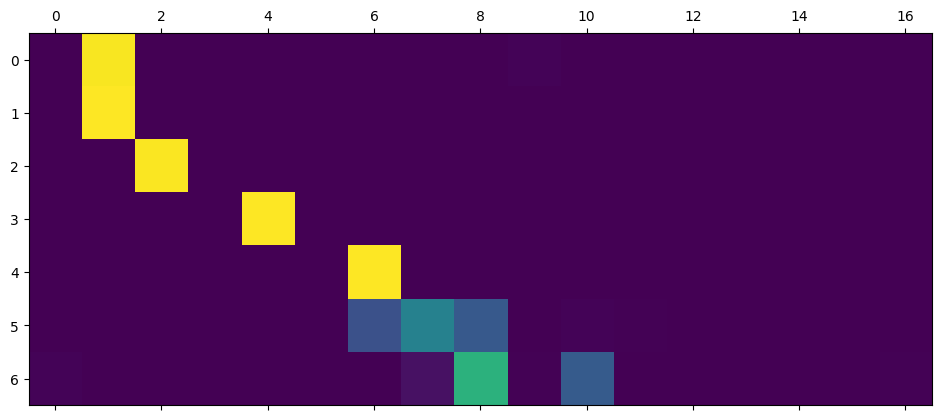

In [40]:
output_words, attentions = evaluate(encoder2, decoder2, "我不确定。")
output_sentence = ' '.join(output_words)
print(output_sentence)

plt.matshow(attentions.numpy())


input = 我不确定。
output = <sos> I 'm not sure . <EOS>


/var/folders/3k/289x66ks5l76g3clryd7kl5c0000gn/T/ipykernel_1246/1027977718.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(input_sentence) +
/var/folders/3k/289x66ks5l76g3clryd7kl5c0000gn/T/ipykernel_1246/1027977718.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


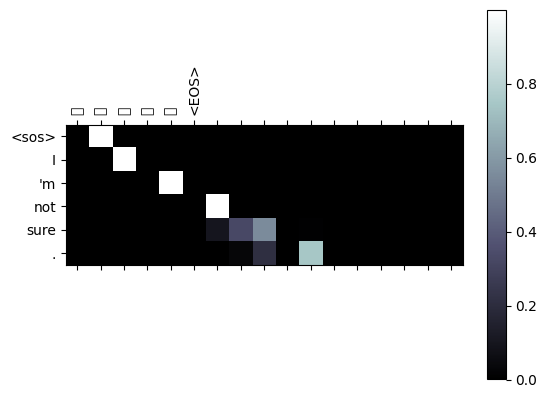

In [45]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + list(input_sentence) +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder2, decoder2, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("我不确定。")


In [ ]:
cn_vocab.get_stoi()['.']